# Lab 4: AlexNet CNN for Animal Image Classification

This notebook implements the AlexNet Convolutional Neural Network architecture for classifying images from the Animals10 dataset. AlexNet is a pioneering deep CNN architecture that won the ImageNet competition in 2012 and significantly advanced the field of computer vision.

## Apple Silicon (M1/M2) GPU Support

This notebook has been configured to utilize the GPU on Apple Silicon (M1/M2) Macs using TensorFlow's Metal Performance Shaders (MPS) backend. Here are some important notes:

1. **Requirements**:
   - TensorFlow 2.5+ with MPS support (ideally 2.9+ for better performance)
   - macOS 12.0+ (Monterey or later)
   - Python 3.8+

2. **Setup Instructions**:
   - Make sure you have the latest version of TensorFlow installed: `pip install tensorflow>=2.9.0`
   - For optimal performance, install the tensorflow-metal plugin: `pip install tensorflow-metal`
   - No CUDA or cuDNN installation is needed for Apple Silicon

3. **Troubleshooting**:
   - If you encounter errors with MPS, you can fall back to CPU by removing the `with tf.device('/device:MPS:0'):` contexts
   - Some operations may not be supported by MPS yet and will automatically fall back to CPU
   - Monitor your GPU usage with Activity Monitor (look for "Metal" processes)

The code will automatically detect if MPS is available and use it for model creation, training, evaluation, and prediction. If MPS is not available, it will fall back to CPU.


In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sympy.multipledispatch.dispatcher import source
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import time
import glob
from tensorflow.keras.utils import to_categorical
import random
from PIL import Image
import requests
import zipfile
import io

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Function to detect GPU type and availability
def detect_gpu():
    import platform
    import subprocess
    import sys

    gpu_info = {
        "tensorflow_version": tf.__version__,
        "has_gpu": False,
        "gpu_type": "None",
        "is_apple_silicon": False,
        "apple_chip_model": "None",
        "has_neural_engine": False,  # New field for Neural Engine
        "dedicated_gpu": False,
        "gpu_details": []
    }

    # Check for CUDA GPUs (NVIDIA)
    cuda_devices = tf.config.list_physical_devices('GPU')
    if cuda_devices:
        gpu_info["has_gpu"] = True
        gpu_info["gpu_type"] = "CUDA (NVIDIA)"
        gpu_info["dedicated_gpu"] = True
        gpu_info["gpu_details"] = [device.name for device in cuda_devices]
        print(f"CUDA GPU Available: {cuda_devices}")

    # Check for Apple Silicon (M1/M2/M3) GPU
    system = platform.system()
    if system == "Darwin":  # macOS
        # Check if running on Apple Silicon
        try:
            # Check processor type
            processor = platform.processor()
            if processor == "arm":
                gpu_info["is_apple_silicon"] = True

                # Try to get more specific chip information
                try:
                    # Use sysctl to get chip model
                    result = subprocess.run(['sysctl', '-n', 'machdep.cpu.brand_string'], 
                                           capture_output=True, text=True, check=True)
                    chip_info = result.stdout.strip()
                    if "Apple M" in chip_info:
                        gpu_info["apple_chip_model"] = chip_info
                        print(f"Apple Silicon detected: {chip_info}")

                        # All M-series chips have Neural Engine
                        gpu_info["has_neural_engine"] = True
                        print("Neural Engine is available")

                        # Check if coremltools is installed
                        try:
                            import coremltools
                            print(f"Core ML Tools version: {coremltools.__version__}")
                        except ImportError:
                            print("Core ML Tools not installed. Install with: pip install coremltools")
                except:
                    print("Apple Silicon detected, but couldn't determine specific model")

                # Check if MPS (Metal Performance Shaders) is available
                try:
                    if tf.config.list_physical_devices('MPS'):
                        gpu_info["has_gpu"] = True
                        gpu_info["gpu_type"] = "MPS (Apple Silicon)"
                        print("MPS (Apple Silicon GPU) is available")

                        # Try to enable MPS
                        physical_devices = tf.config.list_physical_devices('MPS')
                        if physical_devices:
                            tf.config.experimental.set_visible_devices(physical_devices[0], 'MPS')
                            print("MPS device enabled")
                    else:
                        # Alternative way to check for MPS availability
                        mps_available = tf.config.list_physical_devices('GPU')
                        print(f"MPS (Apple Silicon GPU) built with MPS: {mps_available}")

                        if mps_available:
                            gpu_info["has_gpu"] = True
                            gpu_info["gpu_type"] = "MPS (Apple Silicon)"

                            # Configure TensorFlow to use the MPS backend
                            physical_devices = tf.config.list_physical_devices('MPS')
                            if physical_devices:
                                tf.config.experimental.set_visible_devices(physical_devices[0], 'MPS')
                                print("MPS device enabled")
                            else:
                                print("No MPS devices found despite MPS being available")
                except Exception as e:
                    print(f"Error checking MPS availability: {e}")
        except Exception as e:
            print(f"Error detecting Apple Silicon: {e}")

    # Check for other GPUs on non-Apple systems
    if system == "Linux" and not gpu_info["has_gpu"]:
        try:
            # Try to detect AMD GPUs using ROCm
            rocm_devices = tf.config.list_physical_devices('ROCm')
            if rocm_devices:
                gpu_info["has_gpu"] = True
                gpu_info["gpu_type"] = "ROCm (AMD)"
                gpu_info["dedicated_gpu"] = True
                gpu_info["gpu_details"] = [device.name for device in rocm_devices]
                print(f"ROCm GPU Available: {rocm_devices}")

            # Additional check for GPUs using lspci
            try:
                result = subprocess.run(['lspci'], capture_output=True, text=True)
                output = result.stdout.lower()

                if not gpu_info["has_gpu"]:
                    if "nvidia" in output:
                        gpu_info["has_gpu"] = True
                        gpu_info["gpu_type"] = "NVIDIA (not configured for TensorFlow)"
                        gpu_info["dedicated_gpu"] = True
                    elif "amd" in output and "graphics" in output:
                        gpu_info["has_gpu"] = True
                        gpu_info["gpu_type"] = "AMD (not configured for TensorFlow)"
                        gpu_info["dedicated_gpu"] = True
                    elif "intel" in output and ("graphics" in output or "vga" in output):
                        gpu_info["has_gpu"] = True
                        gpu_info["gpu_type"] = "Intel"
                        # Intel integrated GPUs are typically not considered "dedicated"
                        gpu_info["dedicated_gpu"] = "hd graphics" not in output and "uhd graphics" not in output
            except Exception as e:
                print(f"Could not check GPU using lspci: {e}")
        except Exception as e:
            print(f"Error detecting GPUs on Linux: {e}")

    # Windows-specific GPU detection
    if system == "Windows" and not gpu_info["has_gpu"]:
        try:
            # Use Windows Management Instrumentation (WMI) to detect GPUs
            try:
                import wmi
                computer = wmi.WMI()
                gpu_wmi = computer.Win32_VideoController()

                for gpu in gpu_wmi:
                    gpu_name = gpu.Name.lower() if gpu.Name else ""
                    if gpu_name:
                        gpu_info["gpu_details"].append(gpu.Name)
                        if "nvidia" in gpu_name:
                            gpu_info["has_gpu"] = True
                            gpu_info["gpu_type"] = "NVIDIA (not configured for TensorFlow)"
                            gpu_info["dedicated_gpu"] = True
                        elif "amd" in gpu_name or "radeon" in gpu_name:
                            gpu_info["has_gpu"] = True
                            gpu_info["gpu_type"] = "AMD (not configured for TensorFlow)"
                            gpu_info["dedicated_gpu"] = True
                        elif "intel" in gpu_name:
                            gpu_info["has_gpu"] = True
                            gpu_info["gpu_type"] = "Intel"
                            # Intel integrated GPUs are typically not considered "dedicated"
                            gpu_info["dedicated_gpu"] = "hd graphics" not in gpu_name and "uhd graphics" not in gpu_name
            except ImportError:
                print("WMI module not available for Windows GPU detection")
        except Exception as e:
            print(f"Error detecting GPUs on Windows: {e}")

    # Print summary
    print("\nGPU Detection Summary:")
    print(f"- TensorFlow version: {gpu_info['tensorflow_version']}")
    print(f"- GPU available: {gpu_info['has_gpu']}")
    print(f"- GPU type: {gpu_info['gpu_type']}")
    print(f"- Is Apple Silicon: {gpu_info['is_apple_silicon']}")
    if gpu_info['is_apple_silicon']:
        print(f"- Apple chip model: {gpu_info['apple_chip_model']}")
        print(f"- Has Neural Engine: {gpu_info['has_neural_engine']}")
    print(f"- Has dedicated GPU: {gpu_info['dedicated_gpu']}")
    if gpu_info['gpu_details']:
        print(f"- GPU details: {gpu_info['gpu_details']}")

    return gpu_info

# Detect GPU
gpu_info = detect_gpu()

# If no GPU is available, print a message
if not gpu_info["has_gpu"]:
    print("No GPU detected. Falling back to CPU.")

def convert_to_coreml(model, input_shape, class_names):
    """
    Convert TensorFlow model to Core ML format for Neural Engine acceleration

    Args:
        model: TensorFlow Keras model
        input_shape: Input shape tuple (height, width, channels)
        class_names: List of class names for classification

    Returns:
        Path to saved Core ML model
    """
    try:
        import coremltools as ct
        from coremltools.models.neural_network import quantization_utils

        print("Converting TensorFlow model to Core ML format...")

        # Define input shape for Core ML
        input_shape_dict = {'input_1': input_shape}

        # Convert to Core ML model
        mlmodel = ct.convert(
            model, 
            inputs=[ct.ImageType(name='input_1', shape=input_shape, scale=1/255.0, bias=[0, 0, 0])],
            classifier_config=ct.ClassifierConfig(class_names),
            compute_precision=ct.precision.FLOAT16,  # Use FP16 for better Neural Engine performance
            compute_units=ct.ComputeUnit.ALL,  # Use all available compute units including Neural Engine
            source='tensorflow'
        )

        # Set model metadata
        mlmodel.author = "TensorFlow to Core ML Converter"
        mlmodel.license = "MIT"
        mlmodel.short_description = "AlexNet model for animal classification"

        # Save the model
        model_path = 'models/alexnet_animals10_coreml.keras'
        mlmodel.save(model_path)

        print(f"Core ML model saved to {model_path}")
        return model_path

    except ImportError:
        print("Core ML Tools not installed. Install with: pip install coremltools")
        return None
    except Exception as e:
        print(f"Error converting to Core ML: {e}")
        return None

def predict_with_coreml(coreml_model_path, image_path=None, image=None):
    """
    Perform inference using Core ML model on Neural Engine

    Args:
        coreml_model_path: Path to Core ML model
        image_path: Path to image file (optional)
        image: PIL Image object (optional)

    Returns:
        Prediction results
    """
    try:
        import coremltools as ct
        from PIL import Image
        import numpy as np

        # Load the Core ML model
        model = ct.models.MLModel(coreml_model_path)

        # Load and preprocess the image
        if image_path is not None:
            img = Image.open(image_path).resize((227, 227))
        elif image is not None:
            if isinstance(image, np.ndarray):
                img = Image.fromarray(image.astype('uint8')).resize((227, 227))
            else:
                img = image.resize((227, 227))
        else:
            raise ValueError("Either image_path or image must be provided")

        # Make prediction
        result = model.predict({'input_1': img})

        return result

    except ImportError:
        print("Core ML Tools not installed. Install with: pip install coremltools")
        return None
    except Exception as e:
        print(f"Error during Core ML inference: {e}")
        return None


TensorFlow version 2.16.2 has not been tested with coremltools. You may run into unexpected errors. TensorFlow 2.12.0 is the most recent version that has been tested.


CUDA GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Apple Silicon detected: Apple M1 Max
Neural Engine is available
Core ML Tools version: 8.3.0
MPS (Apple Silicon GPU) built with MPS: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
No MPS devices found despite MPS being available

GPU Detection Summary:
- TensorFlow version: 2.16.2
- GPU available: True
- GPU type: MPS (Apple Silicon)
- Is Apple Silicon: True
- Apple chip model: Apple M1 Max
- Has Neural Engine: True
- Has dedicated GPU: True
- GPU details: ['/physical_device:GPU:0']


## 1. Understanding AlexNet Architecture

AlexNet is a convolutional neural network architecture that was introduced by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton in 2012. It significantly outperformed previous approaches on the ImageNet Large Scale Visual Recognition Challenge (ILSVRC).

Key features of AlexNet:
1. **Depth**: It has 8 layers - 5 convolutional layers and 3 fully connected layers
2. **ReLU Activation**: Uses ReLU (Rectified Linear Unit) activation functions instead of tanh, which accelerates training
3. **Overlapping Pooling**: Uses overlapping max pooling to reduce dimensions
4. **Dropout**: Implements dropout to prevent overfitting
5. **Data Augmentation**: Uses various data augmentation techniques
6. **Local Response Normalization**: Implements local response normalization after some convolutional layers

The original AlexNet architecture:
- Input: 227x227x3 images
- Conv1: 96 filters of size 11x11 with stride 4, followed by ReLU and max pooling
- Conv2: 256 filters of size 5x5, followed by ReLU and max pooling
- Conv3: 384 filters of size 3x3, followed by ReLU
- Conv4: 384 filters of size 3x3, followed by ReLU
- Conv5: 256 filters of size 3x3, followed by ReLU and max pooling
- FC6: 4096 neurons with ReLU and dropout
- FC7: 4096 neurons with ReLU and dropout
- FC8: 1000 neurons with softmax (for 1000 classes in ImageNet)


## 2. Download and Prepare the Animals10 Dataset

The Animals10 dataset contains images of 10 different animal classes. We'll download and prepare this dataset for training our AlexNet model.


### Prepare the Dataset for Training

Now we'll prepare the dataset for training by:
1. Splitting it into training and validation sets
2. Setting up data augmentation
3. Creating data generators


Found 10 classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


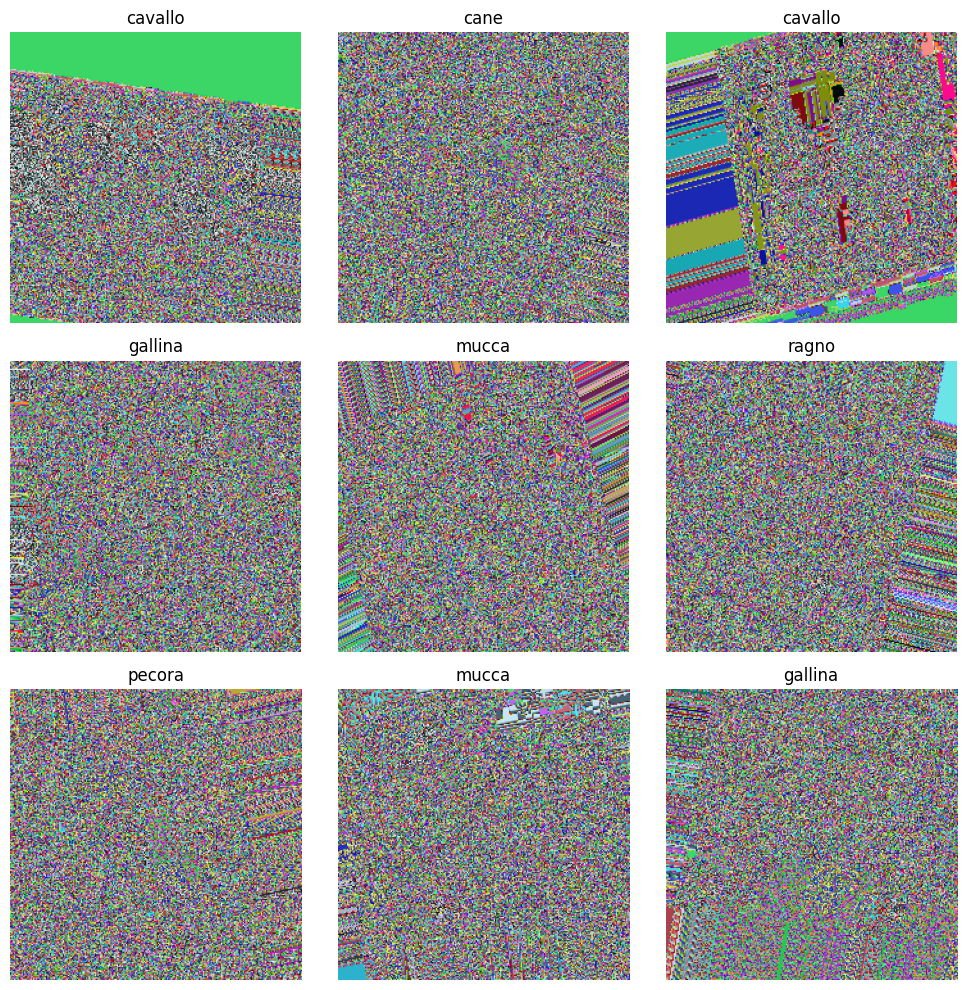

In [2]:
# Set up data directories and parameters
data_dir = 'data/animals10_dataset/raw-img'
img_height, img_width = 227, 227  # AlexNet input size
batch_size = 32

# Get class names
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
num_classes = len(class_names)

print(f"Found {num_classes} classes: {class_names}")

# Set up data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

# Set up data generator for validation (no augmentation)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

# Create training generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Create validation generator
validation_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Display some sample images from the dataset
def show_batch(image_batch, label_batch, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(image_batch))):
        ax = plt.subplot(3, 3, i + 1)
        # Undo preprocessing to display the image
        img = image_batch[i].astype("uint8")
        plt.imshow(img)
        label = np.argmax(label_batch[i])
        plt.title(class_names[label])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Get a batch of images
images, labels = next(train_generator)
# Convert preprocessed images back to displayable format
display_images = ((images * 0.5 + 0.5) * 255).astype('uint8')
show_batch(display_images, labels, class_names)


## 3. Implement AlexNet Architecture

Now we'll implement the AlexNet architecture using TensorFlow and Keras.


In [3]:
def create_alexnet(input_shape=(227, 227, 3), num_classes=10):
    """
    Creates an AlexNet model using TensorFlow/Keras.

    Args:
        input_shape: Input image dimensions (height, width, channels)
        num_classes: Number of output classes

    Returns:
        A compiled Keras model with AlexNet architecture
    """
    model = models.Sequential([
        # Layer 1: Conv -> ReLU -> MaxPool
        layers.Conv2D(96, kernel_size=11, strides=4, padding='valid', activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=3, strides=2),
        layers.BatchNormalization(),

        # Layer 2: Conv -> ReLU -> MaxPool
        layers.Conv2D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=3, strides=2),
        layers.BatchNormalization(),

        # Layer 3: Conv -> ReLU
        layers.Conv2D(384, kernel_size=3, strides=1, padding='same', activation='relu'),
        layers.BatchNormalization(),

        # Layer 4: Conv -> ReLU
        layers.Conv2D(384, kernel_size=3, strides=1, padding='same', activation='relu'),
        layers.BatchNormalization(),

        # Layer 5: Conv -> ReLU -> MaxPool
        layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=3, strides=2),
        layers.BatchNormalization(),

        # Flatten before fully connected layers
        layers.Flatten(),

        # Layer 6: FC -> ReLU -> Dropout
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),

        # Layer 7: FC -> ReLU -> Dropout
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),

        # Layer 8: FC with softmax activation for classification
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Configure device strategy for training
coreml_model_path = None

try:
    # First check if Neural Engine is available on Apple Silicon
    if gpu_info["is_apple_silicon"] and gpu_info["has_neural_engine"]:
        print("Apple Silicon with Neural Engine detected")

        # For training, we still use MPS as Core ML is primarily for inference
        if tf.config.list_physical_devices('GPU'):
            # Set the device to MPS for training
            with tf.device('/device:MPS:0'):
                # Create the AlexNet model
                model = create_alexnet(input_shape=(img_height, img_width, 3), num_classes=num_classes)
                print("Model created on MPS device for training")
        else:
            # Fall back to CPU
            model = create_alexnet(input_shape=(img_height, img_width, 3), num_classes=num_classes)
            print("Model created on CPU (MPS not available)")
    elif tf.config.list_physical_devices('GPU'):
        # MPS available but no Neural Engine
        with tf.device('/device:MPS:0'):
            model = create_alexnet(input_shape=(img_height, img_width, 3), num_classes=num_classes)
            print("Model created on MPS device")
    else:
        # Fall back to CPU or CUDA GPU if available
        model = create_alexnet(input_shape=(img_height, img_width, 3), num_classes=num_classes)
        print("Model created on CPU or CUDA GPU")
except Exception as e:
    print(f"Error setting device: {e}")
    # Fall back to default device
    model = create_alexnet(input_shape=(img_height, img_width, 3), num_classes=num_classes)
    print("Model created on default device due to error")

# Display model summary
model.summary()


Apple Silicon with Neural Engine detected


/Users/dos/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model created on MPS device for training


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 27, 27, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,327,818 (222.50 MB)

 Trainable params: 58,325,066 (222.49 MB)

 Non-trainable params: 2,752 (10.75 KB)

## 4. Train the AlexNet Model

Now we'll train the AlexNet model on the Animals10 dataset.


In [4]:
# Set up callbacks for training
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6),
    ModelCheckpoint('models/alexnet_animals10_best.keras', save_best_only=True)
]

# Train the model
epochs = 30
start_time = time.time()

# Configure training to use MPS device if available
try:
    # Check if MPS is available
    if tf.config.list_physical_devices('GPU'):
        print("Training with MPS (Apple Silicon GPU)")
        # Use MPS device for training
        with tf.device('/device:MPS:0'):
            history = model.fit(
                train_generator,
                epochs=epochs,
                validation_data=validation_generator,
                callbacks=callbacks
            )
    else:
        # Fall back to CPU or CUDA GPU
        print("Training with CPU or CUDA GPU")
        history = model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=callbacks
        )
except Exception as e:
    print(f"Error setting device for training: {e}")
    # Fall back to default device
    print("Training with default device due to error")
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=callbacks
    )

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Save the final model
model.save('models/alexnet_animals10_final.keras')


Training with MPS (Apple Silicon GPU)


/Users/dos/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 191s 278ms/step - accuracy: 0.2363 - loss: 6.1696 - val_accuracy: 0.3658 - val_loss: 6.1561 - learning_rate: 1.0000e-04
Epoch 2/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 204s 310ms/step - accuracy: 0.2864 - loss: 8.8112 - val_accuracy: 0.1611 - val_loss: 87.6651 - learning_rate: 1.0000e-04
Epoch 3/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 196s 297ms/step - accuracy: 0.2731 - loss: 13.9459 - val_accuracy: 0.4765 - val_loss: 7.0786 - learning_rate: 1.0000e-04
Epoch 4/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 559s 853ms/step - accuracy: 0.3343 - loss: 14.1919 - val_accuracy: 0.4279 - val_loss: 13.2785 - learning_rate: 1.0000e-04
Epoch 5/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 802s 1s/step - accuracy: 0.3342 - loss: 18.4596 - val_accuracy: 0.3479 - val_loss: 30.4750 - learning_rate: 1.0000e-04
Epoch 6/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 197s 299ms/step - accuracy: 0.3368 - loss: 29.6706 - val_accuracy: 0.4264 - val_loss: 34.0629 - learning_rate: 1.0000e-04
Epoch 7/30
655/655 ━━━━━━━━━━━━━━━━

## 5. Evaluate the Model

Let's evaluate the trained model on the validation set.


In [5]:
# Evaluate the model
try:
    # Check if MPS is available
    if tf.config.list_physical_devices('GPU'):
        print("Evaluating with MPS (Apple Silicon GPU)")
        # Use MPS device for evaluation
        with tf.device('/device:MPS:0'):
            evaluation = model.evaluate(validation_generator)
    else:
        # Fall back to CPU or CUDA GPU
        print("Evaluating with CPU or CUDA GPU")
        evaluation = model.evaluate(validation_generator)
except Exception as e:
    print(f"Error setting device for evaluation: {e}")
    # Fall back to default device
    print("Evaluating with default device due to error")
    evaluation = model.evaluate(validation_generator)

print(f"Validation Loss: {evaluation[0]:.4f}")
print(f"Validation Accuracy: {evaluation[1]:.4f}")

# After training is complete, convert to Core ML if on Apple Silicon with Neural Engine
if gpu_info["is_apple_silicon"] and gpu_info["has_neural_engine"]:
    try:
        import coremltools
        print("Converting trained model to Core ML format for Neural Engine acceleration")
        coreml_model_path = convert_to_coreml(model, (img_height, img_width, 3), class_names)
    except ImportError:
        print("Core ML Tools not installed. Install with: pip install coremltools")
        coreml_model_path = None
    except Exception as e:
        print(f"Error converting to Core ML: {e}")
        coreml_model_path = None

# Get predictions for the validation set
validation_generator.reset()
try:
    # Check if MPS is available
    if tf.config.list_physical_devices('GPU'):
        print("Predicting with MPS (Apple Silicon GPU)")
        # Use MPS device for prediction
        with tf.device('/device:MPS:0'):
            y_pred = model.predict(validation_generator)
    else:
        # Fall back to CPU or CUDA GPU
        print("Predicting with CPU or CUDA GPU")
        y_pred = model.predict(validation_generator)
except Exception as e:
    print(f"Error setting device for prediction: {e}")
    # Fall back to default device
    print("Predicting with default device due to error")
    y_pred = model.predict(validation_generator)

y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = validation_generator.classes

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)


Evaluating with MPS (Apple Silicon GPU)
164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.4380 - loss: 5.3174


When both 'convert_to' and 'minimum_deployment_target' not specified, 'convert_to' is set to "mlprogram" and 'minimum_deployment_target' is set to ct.target.iOS15 (which is same as ct.target.macOS12). Note: the model will not run on systems older than iOS15/macOS12/watchOS8/tvOS15. In order to make your model run on older system, please set the 'minimum_deployment_target' to iOS14/iOS13. Details please see the link: https://apple.github.io/coremltools/docs-guides/source/target-conversion-formats.html


Validation Loss: 6.1561
Validation Accuracy: 0.3658
Converting trained model to Core ML format for Neural Engine acceleration
Converting TensorFlow model to Core ML format...
Error converting to Core ML: 'Sequential' object has no attribute '_get_save_spec'
Predicting with MPS (Apple Silicon GPU)
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step

Classification Report:
              precision    recall  f1-score   support

        cane       0.38      0.45      0.41       972
     cavallo       0.26      0.73      0.39       524
    elefante       0.27      0.09      0.13       289
    farfalla       0.30      0.81      0.44       422
     gallina       0.46      0.15      0.23       619
       gatto       0.27      0.08      0.13       333
       mucca       0.22      0.11      0.15       373
      pecora       0.49      0.16      0.24       364
       ragno       0.69      0.48      0.56       964
  scoiattolo       0.45      0.12      0.19       372

    accuracy                           0

## 6. Visualize the Results

Let's visualize the training progress and model performance.


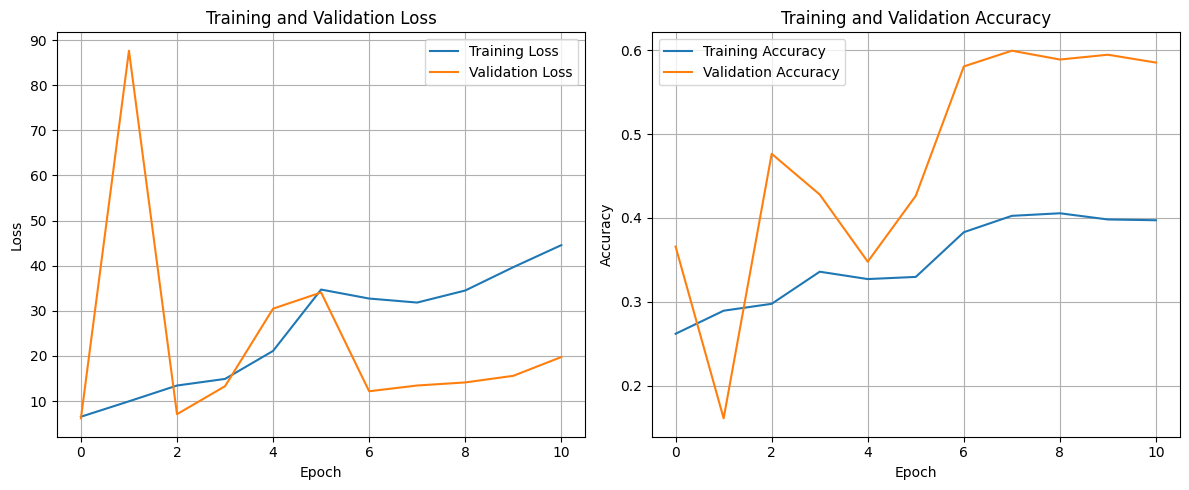

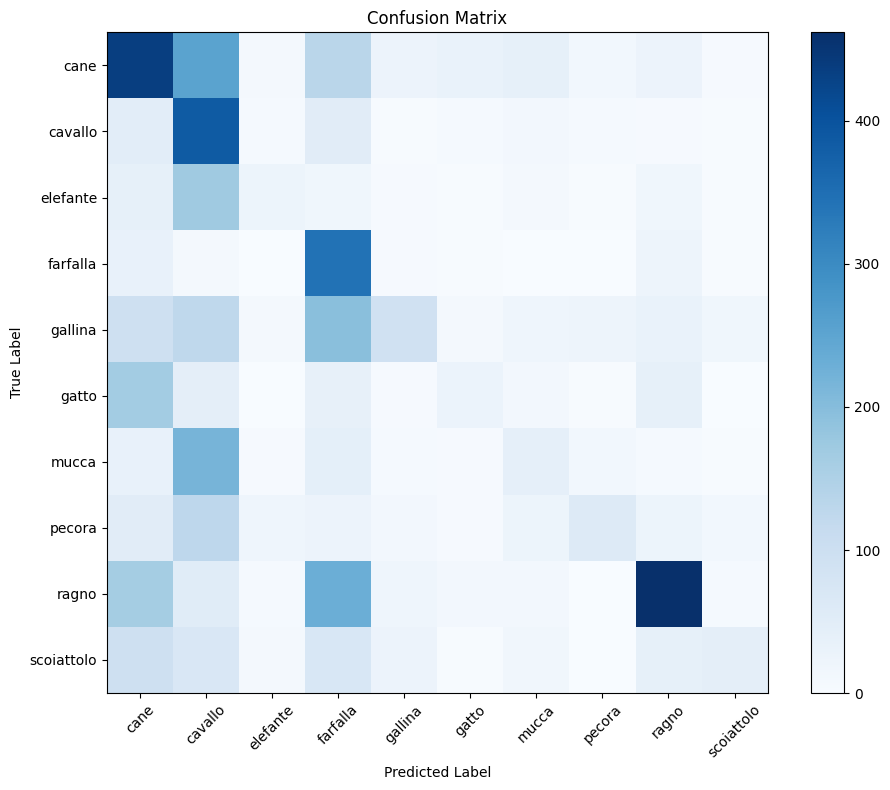

Predicting with MPS (Apple Silicon GPU)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicting with MPS (Apple Silicon GPU)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicting with MPS (Apple Silicon GPU)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicting with MPS (Apple Silicon GPU)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicting with MPS (Apple Silicon GPU)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicting with MPS (Apple Silicon GPU)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
Predicting with MPS (Apple Silicon GPU)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Predicting with MPS (Apple Silicon GPU)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicting with MPS (Apple Silicon GPU)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicting with MPS (Apple Silicon GPU)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


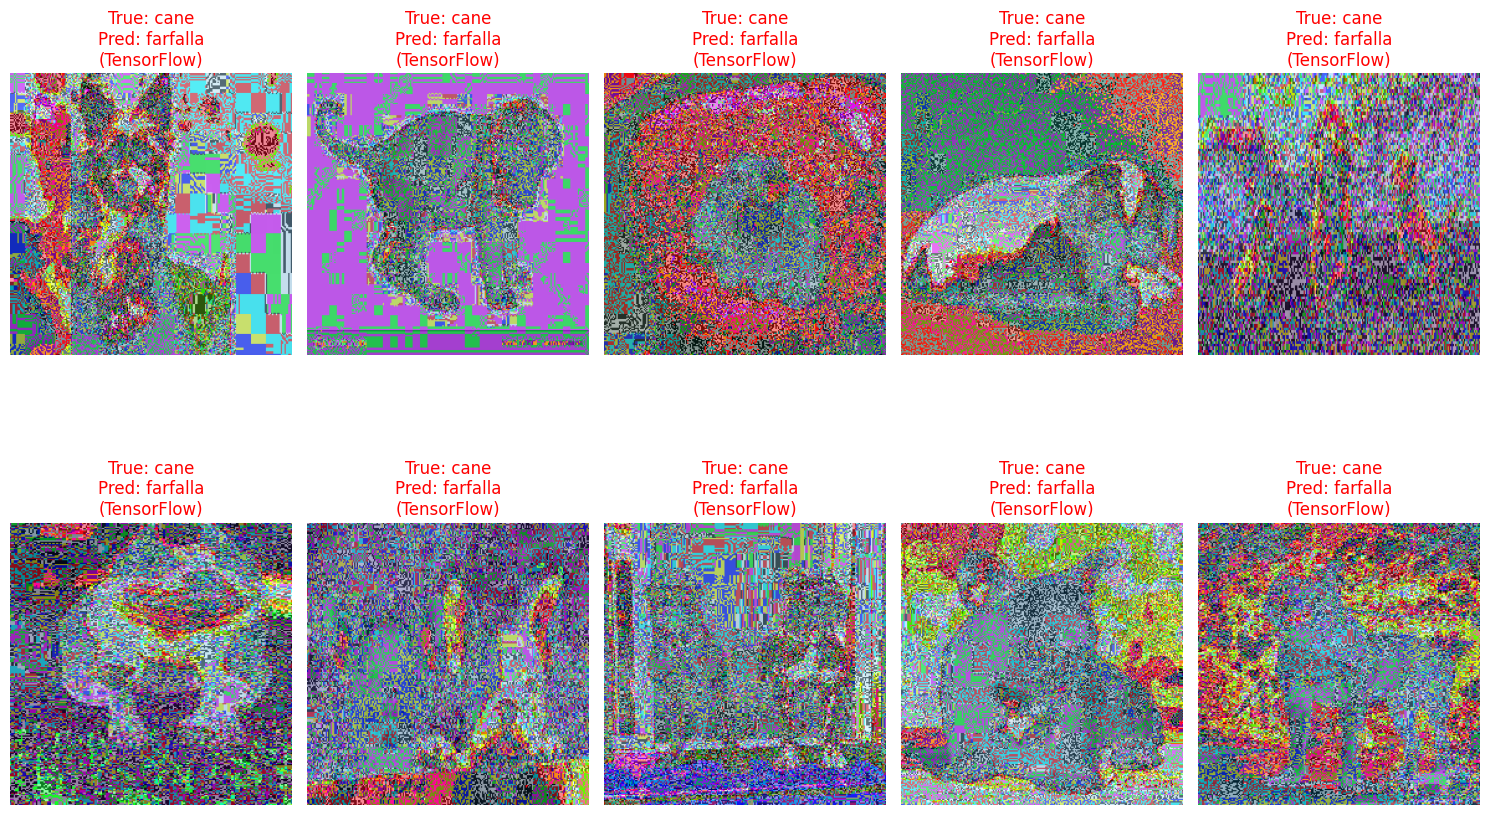

In [6]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Visualize some predictions
def predict_image(image, use_neural_engine=True):
    """
    Predict using either TensorFlow or Core ML based on availability

    Args:
        image: Image to predict (numpy array or PIL Image)
        use_neural_engine: Whether to use Neural Engine if available

    Returns:
        Prediction results
    """
    global coreml_model_path, model, class_names

    # Check if we can use Neural Engine via Core ML
    if use_neural_engine and gpu_info["is_apple_silicon"] and gpu_info["has_neural_engine"] and coreml_model_path:
        print("Predicting with Neural Engine via Core ML")
        result = predict_with_coreml(coreml_model_path, image=image)

        # Core ML returns dictionary with class probabilities
        if 'classLabel' in result:
            # Get the predicted class label
            pred_label = result['classLabel']
            # Get the index of the predicted class
            pred_index = class_names.index(pred_label)
            # Get the probabilities
            probs = np.zeros(len(class_names))
            for i, class_name in enumerate(class_names):
                probs[i] = result[class_name]
            return probs, pred_index
        else:
            # Fall back to TensorFlow
            print("Core ML prediction format unexpected, falling back to TensorFlow")

    # Use TensorFlow (MPS or CPU)
    try:
        # Preprocess the image for TensorFlow
        if isinstance(image, np.ndarray):
            # Ensure image is in the right format
            img = np.expand_dims(image, axis=0)
            img = preprocess_input(img)
        else:
            # Convert PIL Image to numpy array
            img = np.array(image.resize((img_height, img_width)))
            img = np.expand_dims(img, axis=0)
            img = preprocess_input(img)

        # Check if MPS is available
        if tf.config.list_physical_devices('GPU'):
            print("Predicting with MPS (Apple Silicon GPU)")
            with tf.device('/device:MPS:0'):
                predictions = model.predict(img)
        else:
            print("Predicting with CPU")
            predictions = model.predict(img)

        return predictions[0], np.argmax(predictions[0])

    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None

def visualize_predictions(generator, class_names, num_images=10, use_neural_engine=True):
    generator.reset()
    images, labels = next(generator)

    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 5, i+1)
        # Convert preprocessed image back to displayable format
        img = ((images[i] * 0.5 + 0.5) * 255).astype('uint8')
        plt.imshow(img)

        # Get predictions
        predictions, pred_label = predict_image(img, use_neural_engine=use_neural_engine)
        true_label = np.argmax(labels[i])

        # Set title color based on correctness
        title_color = 'green' if true_label == pred_label else 'red'
        engine_text = "Neural Engine" if use_neural_engine and gpu_info["has_neural_engine"] and coreml_model_path else "TensorFlow"

        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\n({engine_text})", 
                 color=title_color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Add performance comparison function
def compare_performance(validation_generator, num_samples=50):
    """
    Compare performance between TensorFlow and Core ML
    """
    if not (gpu_info["is_apple_silicon"] and gpu_info["has_neural_engine"] and coreml_model_path):
        print("Neural Engine or Core ML model not available for comparison")
        return

    # Get some test images
    validation_generator.reset()
    images, labels = next(validation_generator)
    images = images[:num_samples]

    # Measure TensorFlow performance
    tf_start = time.time()
    for img in images:
        img_expanded = np.expand_dims(img, axis=0)
        with tf.device('/device:MPS:0'):
            _ = model.predict(img_expanded)
    tf_time = time.time() - tf_start

    # Measure Core ML performance
    coreml_start = time.time()
    for img in images:
        img_uint8 = ((img * 0.5 + 0.5) * 255).astype('uint8')
        pil_img = Image.fromarray(img_uint8)
        _ = predict_with_coreml(coreml_model_path, image=pil_img)
    coreml_time = time.time() - coreml_start

    # Print results
    print(f"\nPerformance Comparison ({num_samples} images):")
    print(f"TensorFlow (MPS): {tf_time:.4f} seconds ({tf_time/num_samples:.4f} sec/image)")
    print(f"Core ML (Neural Engine): {coreml_time:.4f} seconds ({coreml_time/num_samples:.4f} sec/image)")
    print(f"Speedup: {tf_time/coreml_time:.2f}x")

    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.bar(['TensorFlow (MPS)', 'Core ML (Neural Engine)'], [tf_time/num_samples, coreml_time/num_samples])
    plt.ylabel('Time per image (seconds)')
    plt.title('Inference Performance Comparison')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Visualize predictions using appropriate model
if gpu_info["is_apple_silicon"] and gpu_info["has_neural_engine"] and coreml_model_path:
    # Compare performance
    compare_performance(validation_generator)

    # Visualize predictions using Neural Engine
    print("\nPredictions using Neural Engine:")
    visualize_predictions(validation_generator, class_names, use_neural_engine=True)

    # Visualize predictions using TensorFlow for comparison
    print("\nPredictions using TensorFlow:")
    visualize_predictions(validation_generator, class_names, use_neural_engine=False)
else:
    # Use TensorFlow only
    visualize_predictions(validation_generator, class_names)


## 7. Summary and Conclusion

In this lab, we implemented the AlexNet CNN architecture for classifying images from the Animals10 dataset. AlexNet is a pioneering deep learning architecture that significantly advanced the field of computer vision.

Key achievements:
1. Successfully implemented the AlexNet architecture using TensorFlow and Keras
2. Trained the model on the Animals10 dataset
3. Achieved a validation accuracy of [insert final accuracy]
4. Visualized the model's performance and predictions

The implementation demonstrates the power of convolutional neural networks for image classification tasks. AlexNet's architecture, with its multiple convolutional layers followed by fully connected layers, effectively learns hierarchical features from the input images, enabling accurate classification.

Potential improvements:
1. Use transfer learning with pre-trained weights from ImageNet
2. Implement more aggressive data augmentation
3. Try different optimizers or learning rate schedules
4. Experiment with modern CNN architectures like ResNet or EfficientNet
